<h1>Parkinson's Disease Detection - 201036</h1>


<h3>Attribute Information:</h3>
<ul>
  <li>name - ASCII subject name and recording number</li>
  <li>MDVP:Fo(Hz) - Average vocal fundamental frequency</li>
  <li>MDVP:Fhi(Hz) - Maximum vocal fundamental frequency</li>
  <li>MDVP:Flo(Hz) - Minimum vocal fundamental frequency</li>
  <li>MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several measures of variation in fundamental frequency</li>
  <li>MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude</li>
  <li>NHR,HNR - Two measures of the ratio of noise to tonal components in the voice</li>
  <li>RPDE,D2 - Two nonlinear dynamical complexity measures</li>
  <li>DFA - Signal fractal scaling exponent</li>
  <li>spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation</li>
  <li><b>status (target)</b> - Health status of the subject (one) - Parkinson's, (zero) - healthy</li>

</ul>


In [1]:
import pandas as pd
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

<h1>Exploratory Data Analysis</h1>


<h3>Loading Dataset</h3>


In [2]:
data = pd.read_csv("./parkinsons.data", sep=",", index_col="name")
data.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
name,,,,,,,,,,,,,,,,,,,,,
phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [3]:
print(f"Number of missing values: {data.isna().sum().sum()}")
print(f"Number of duplicates: {data.duplicated().sum()}")

Number of missing values: 0
Number of duplicates: 0


In [4]:
data.head(12)

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
name,,,,,,,,,,,,,,,,,,,,,
phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
phon_R01_S01_6,120.552,131.162,113.787,0.00968,0.00008,0.00463,0.00750,0.01388,0.04701,0.456,...,0.06985,0.01222,21.378,1,0.415564,0.825069,-4.242867,0.299111,2.187560,0.357775
phon_R01_S02_1,120.267,137.244,114.820,0.00333,0.00003,0.00155,0.00202,0.00466,0.01608,0.140,...,0.02337,0.00607,24.886,1,0.596040,0.764112,-5.634322,0.257682,1.854785,0.211756
phon_R01_S02_2,107.332,113.840,104.315,0.00290,0.00003,0.00144,0.00182,0.00431,0.01567,0.134,...,0.02487,0.00344,26.892,1,0.637420,0.763262,-6.167603,0.183721,2.064693,0.163755
phon_R01_S02_3,95.730,132.068,91.754,0.00551,0.00006,0.00293,0.00332,0.00880,0.02093,0.191,...,0.03218,0.01070,21.812,1,0.615551,0.773587,-5.498678,0.327769,2.322511,0.231571


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195 entries, phon_R01_S01_1 to phon_R01_S50_6
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MDVP:Fo(Hz)       195 non-null    float64
 1   MDVP:Fhi(Hz)      195 non-null    float64
 2   MDVP:Flo(Hz)      195 non-null    float64
 3   MDVP:Jitter(%)    195 non-null    float64
 4   MDVP:Jitter(Abs)  195 non-null    float64
 5   MDVP:RAP          195 non-null    float64
 6   MDVP:PPQ          195 non-null    float64
 7   Jitter:DDP        195 non-null    float64
 8   MDVP:Shimmer      195 non-null    float64
 9   MDVP:Shimmer(dB)  195 non-null    float64
 10  Shimmer:APQ3      195 non-null    float64
 11  Shimmer:APQ5      195 non-null    float64
 12  MDVP:APQ          195 non-null    float64
 13  Shimmer:DDA       195 non-null    float64
 14  NHR               195 non-null    float64
 15  HNR               195 non-null    float64
 16  status            195 non

<h3>Spearman Correlation Matrix</h3>

Relatively high correlation between features, even if sometimes is negavtive.

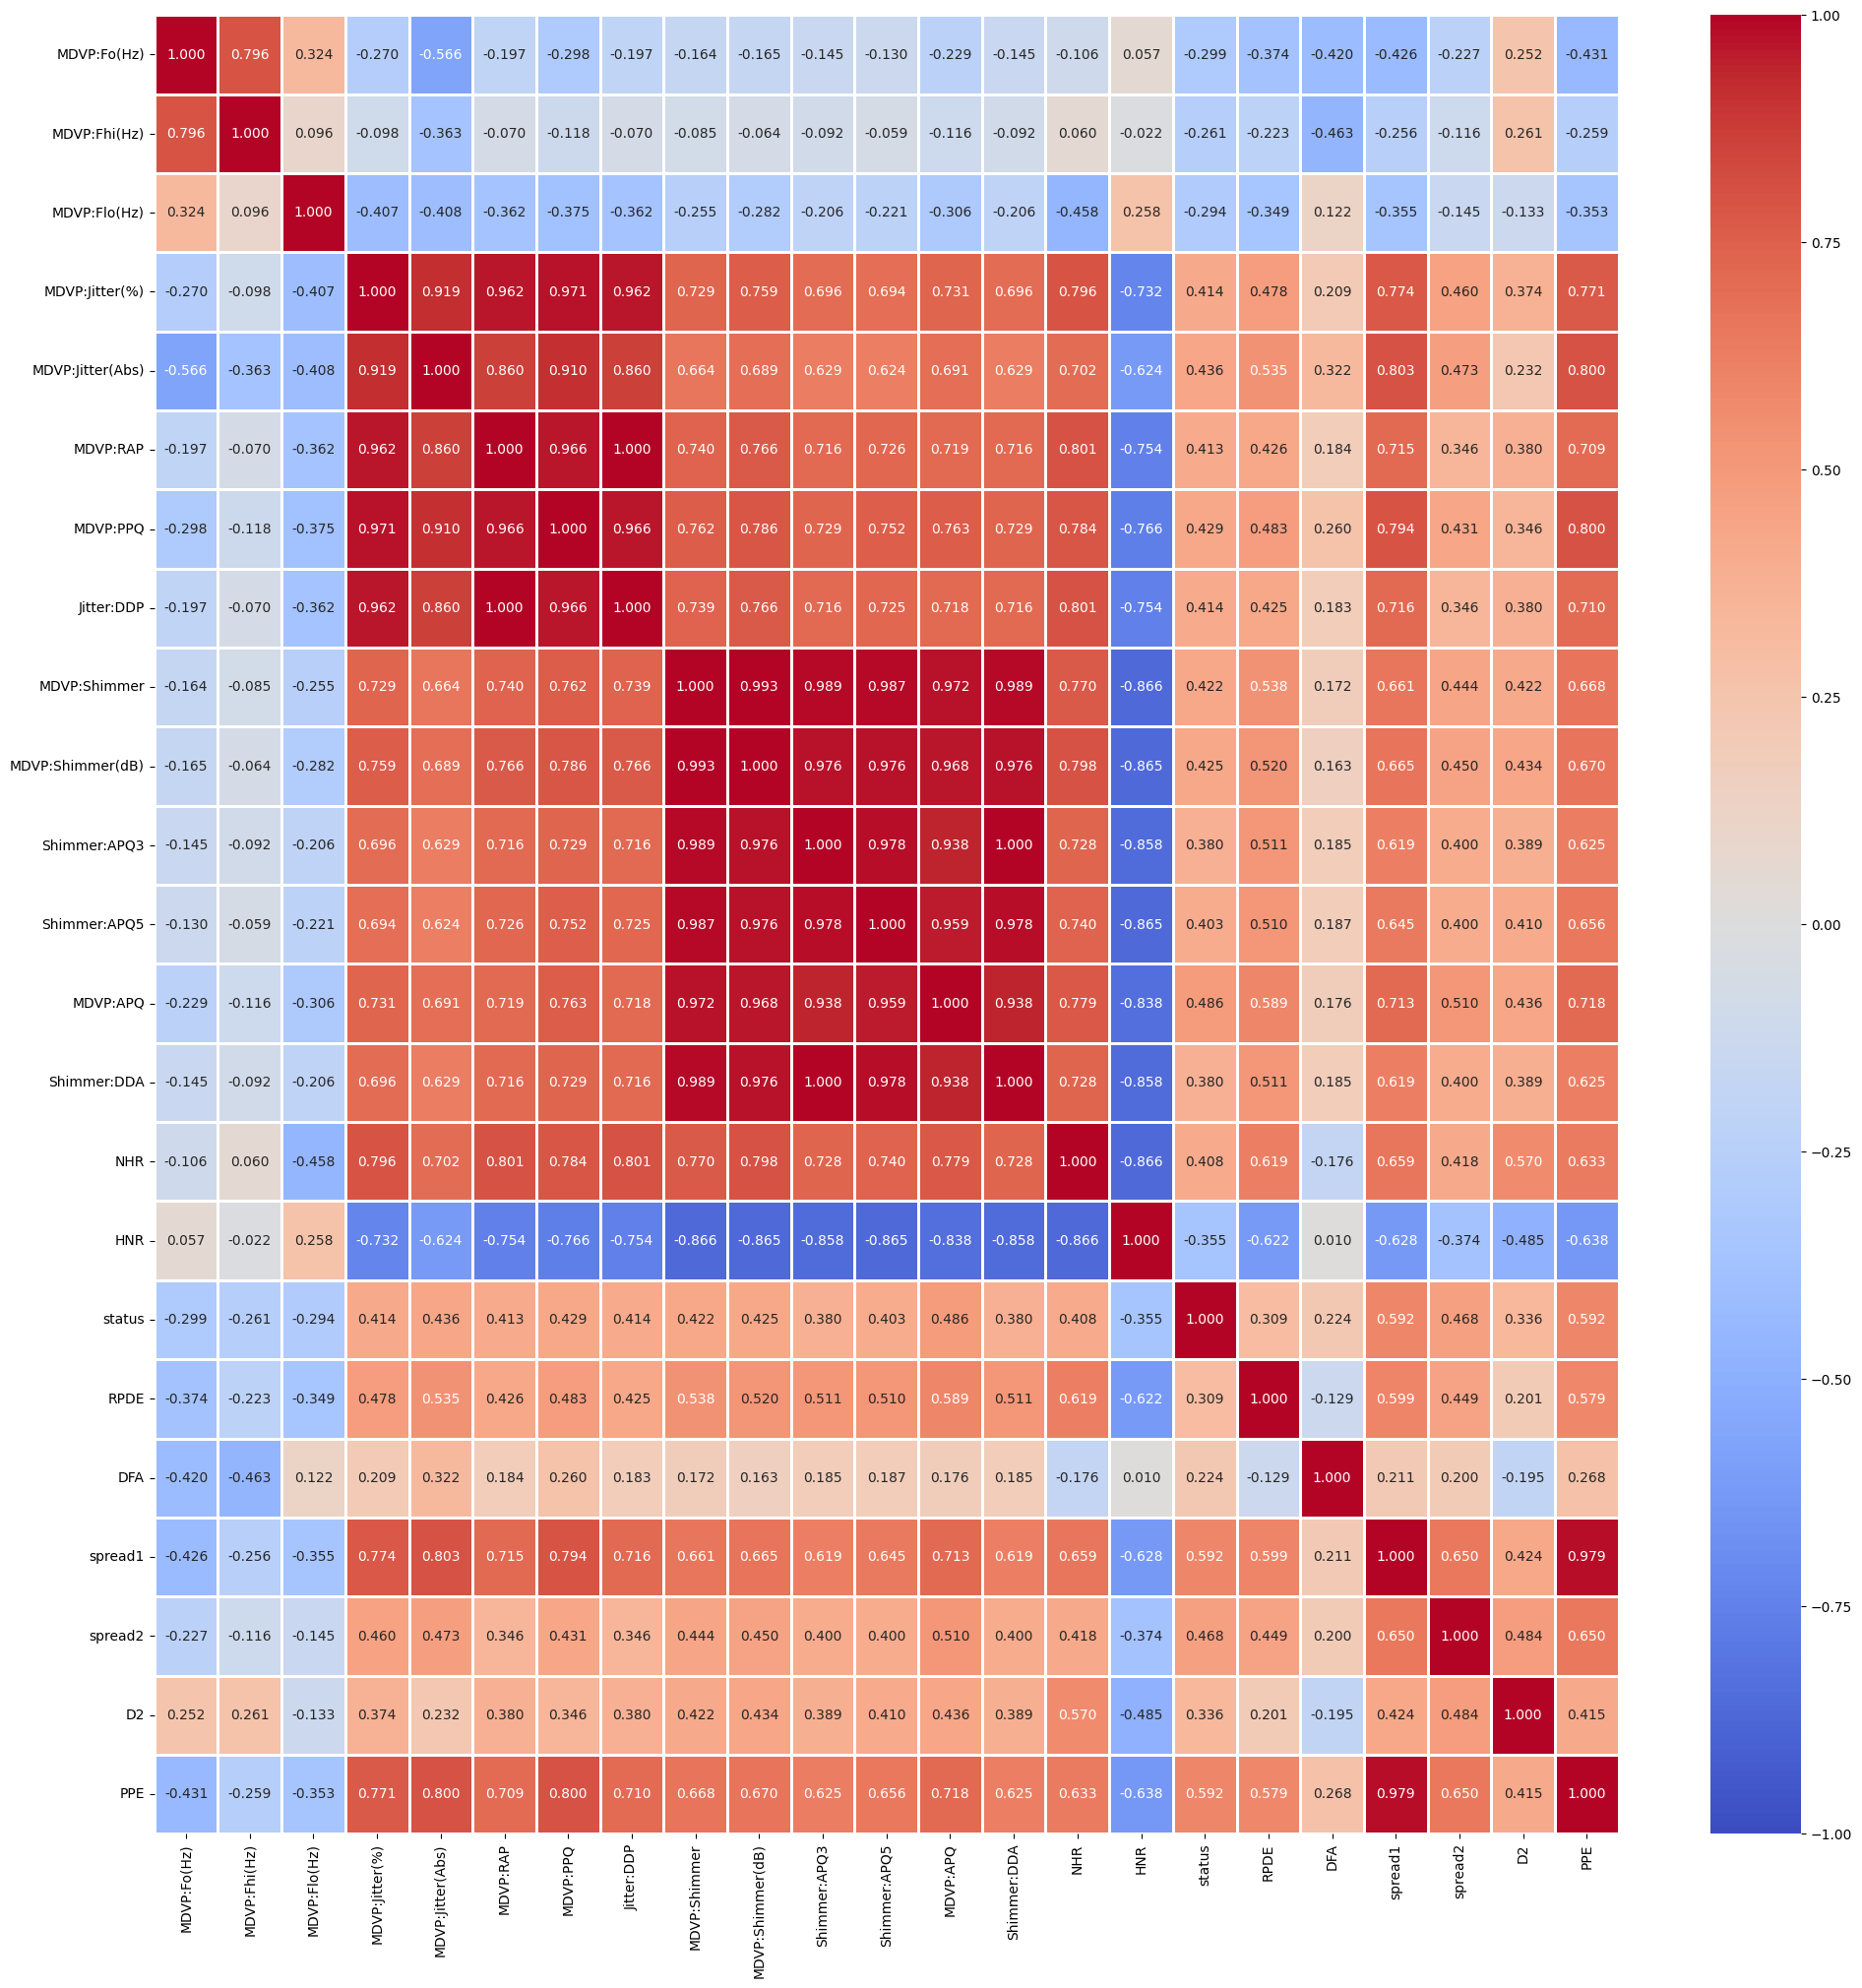

In [8]:
plt.figure(figsize=(24, 24))
sns.heatmap(
    data.corr(method="spearman"),
    annot=True,
    vmin=-1,
    vmax=1,
    fmt=".3f",
    linewidths=2,
    cmap="coolwarm",
)
plt.show()

<h3>Spearman Correlation Matrix with Target Feature</h3>

There is no strong correlation between feature and status, but that means that every feature is important in dataset.

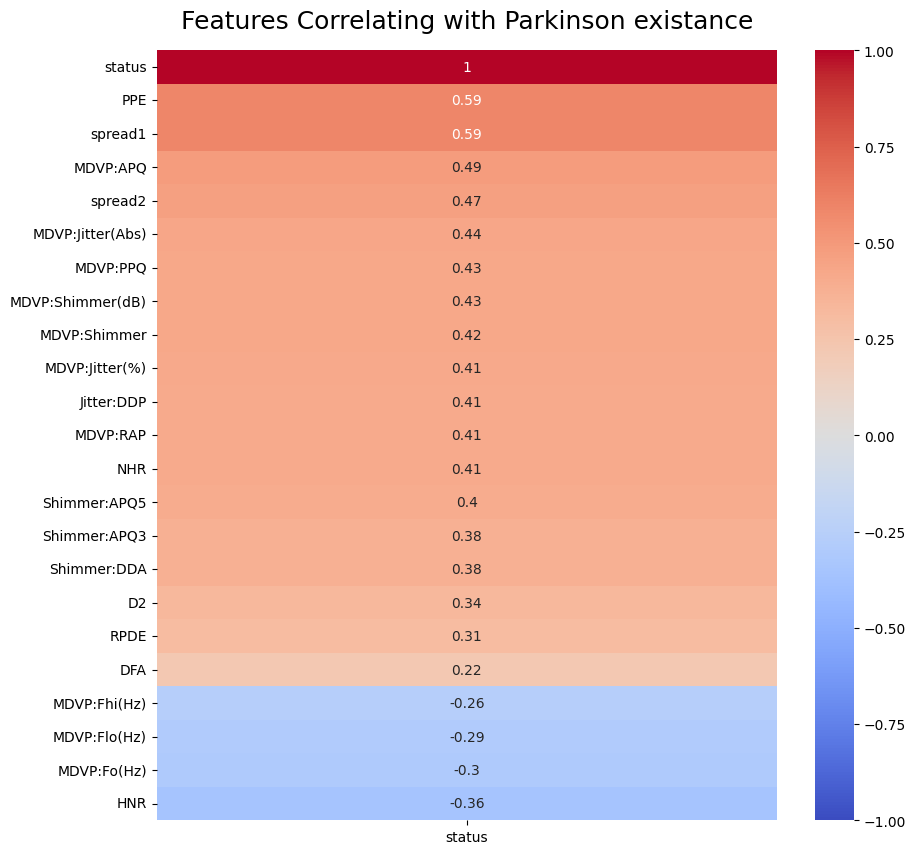

In [9]:
from matplotlib.pyplot import plot, savefig

plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(
    data.corr(method="spearman")[["status"]].sort_values(by="status", ascending=False),
    vmin=-1,
    vmax=1,
    annot=True,
    cmap="coolwarm",
)
heatmap.set_title(
    "Features Correlating with Parkinson existance", fontdict={"fontsize": 18}, pad=16
)

<h3>Value of Target - Status by Patient</h3>

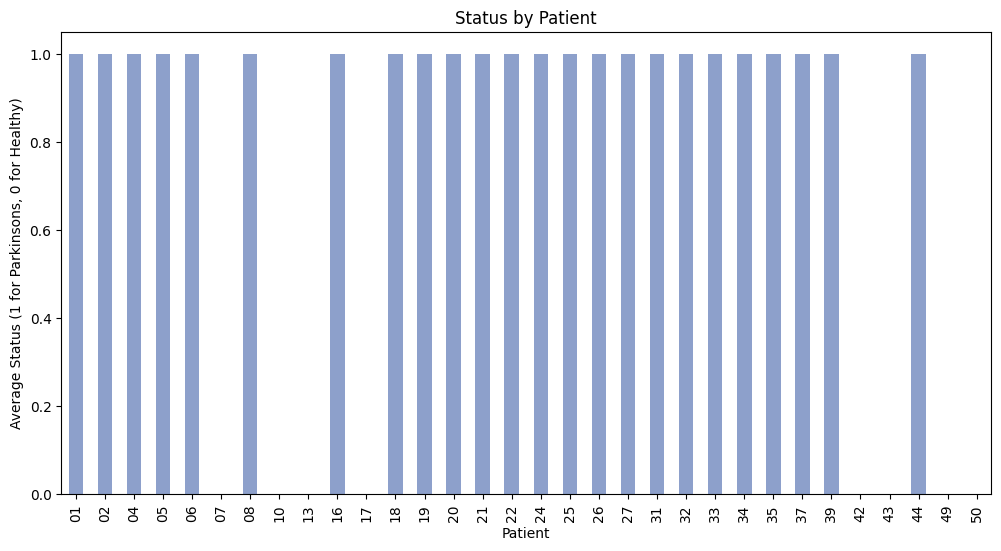

<Figure size 640x480 with 0 Axes>

In [10]:
df = data.copy()

df["patient"] = df.index.str.extract(r"phon_R01_S(\d+)_\d+", expand=False)

average_status_by_patient = df.groupby("patient")["status"].mean()

plt.figure(figsize=(12, 6))
average_status_by_patient.plot(kind="bar", color="#8da0cb")
plt.title("Status by Patient")
plt.xlabel("Patient")
plt.ylabel("Average Status (1 for Parkinsons, 0 for Healthy)")
plt.show()



<h3>Frequency of Target - Status</h3>

Dataset is not balanced.

C:\Users\User\AppData\Local\Temp\ipykernel_16704\3640612365.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="status", palette="Set2")


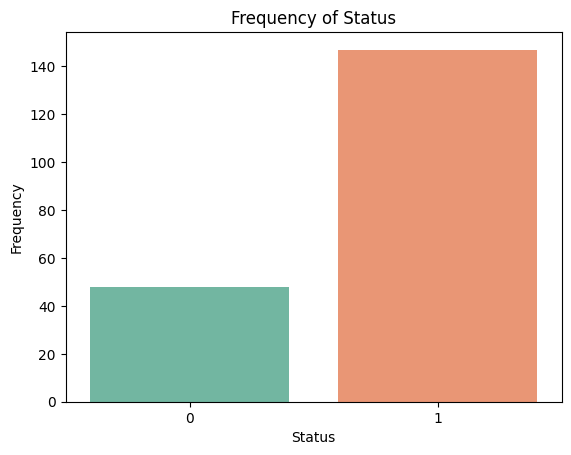

<Figure size 640x480 with 0 Axes>

In [11]:
sns.countplot(data=data, x="status", palette="Set2")

plt.xlabel("Status")
plt.ylabel("Frequency")
plt.title("Frequency of Status")

plt.show()


<h3>Distribution of features</h3>

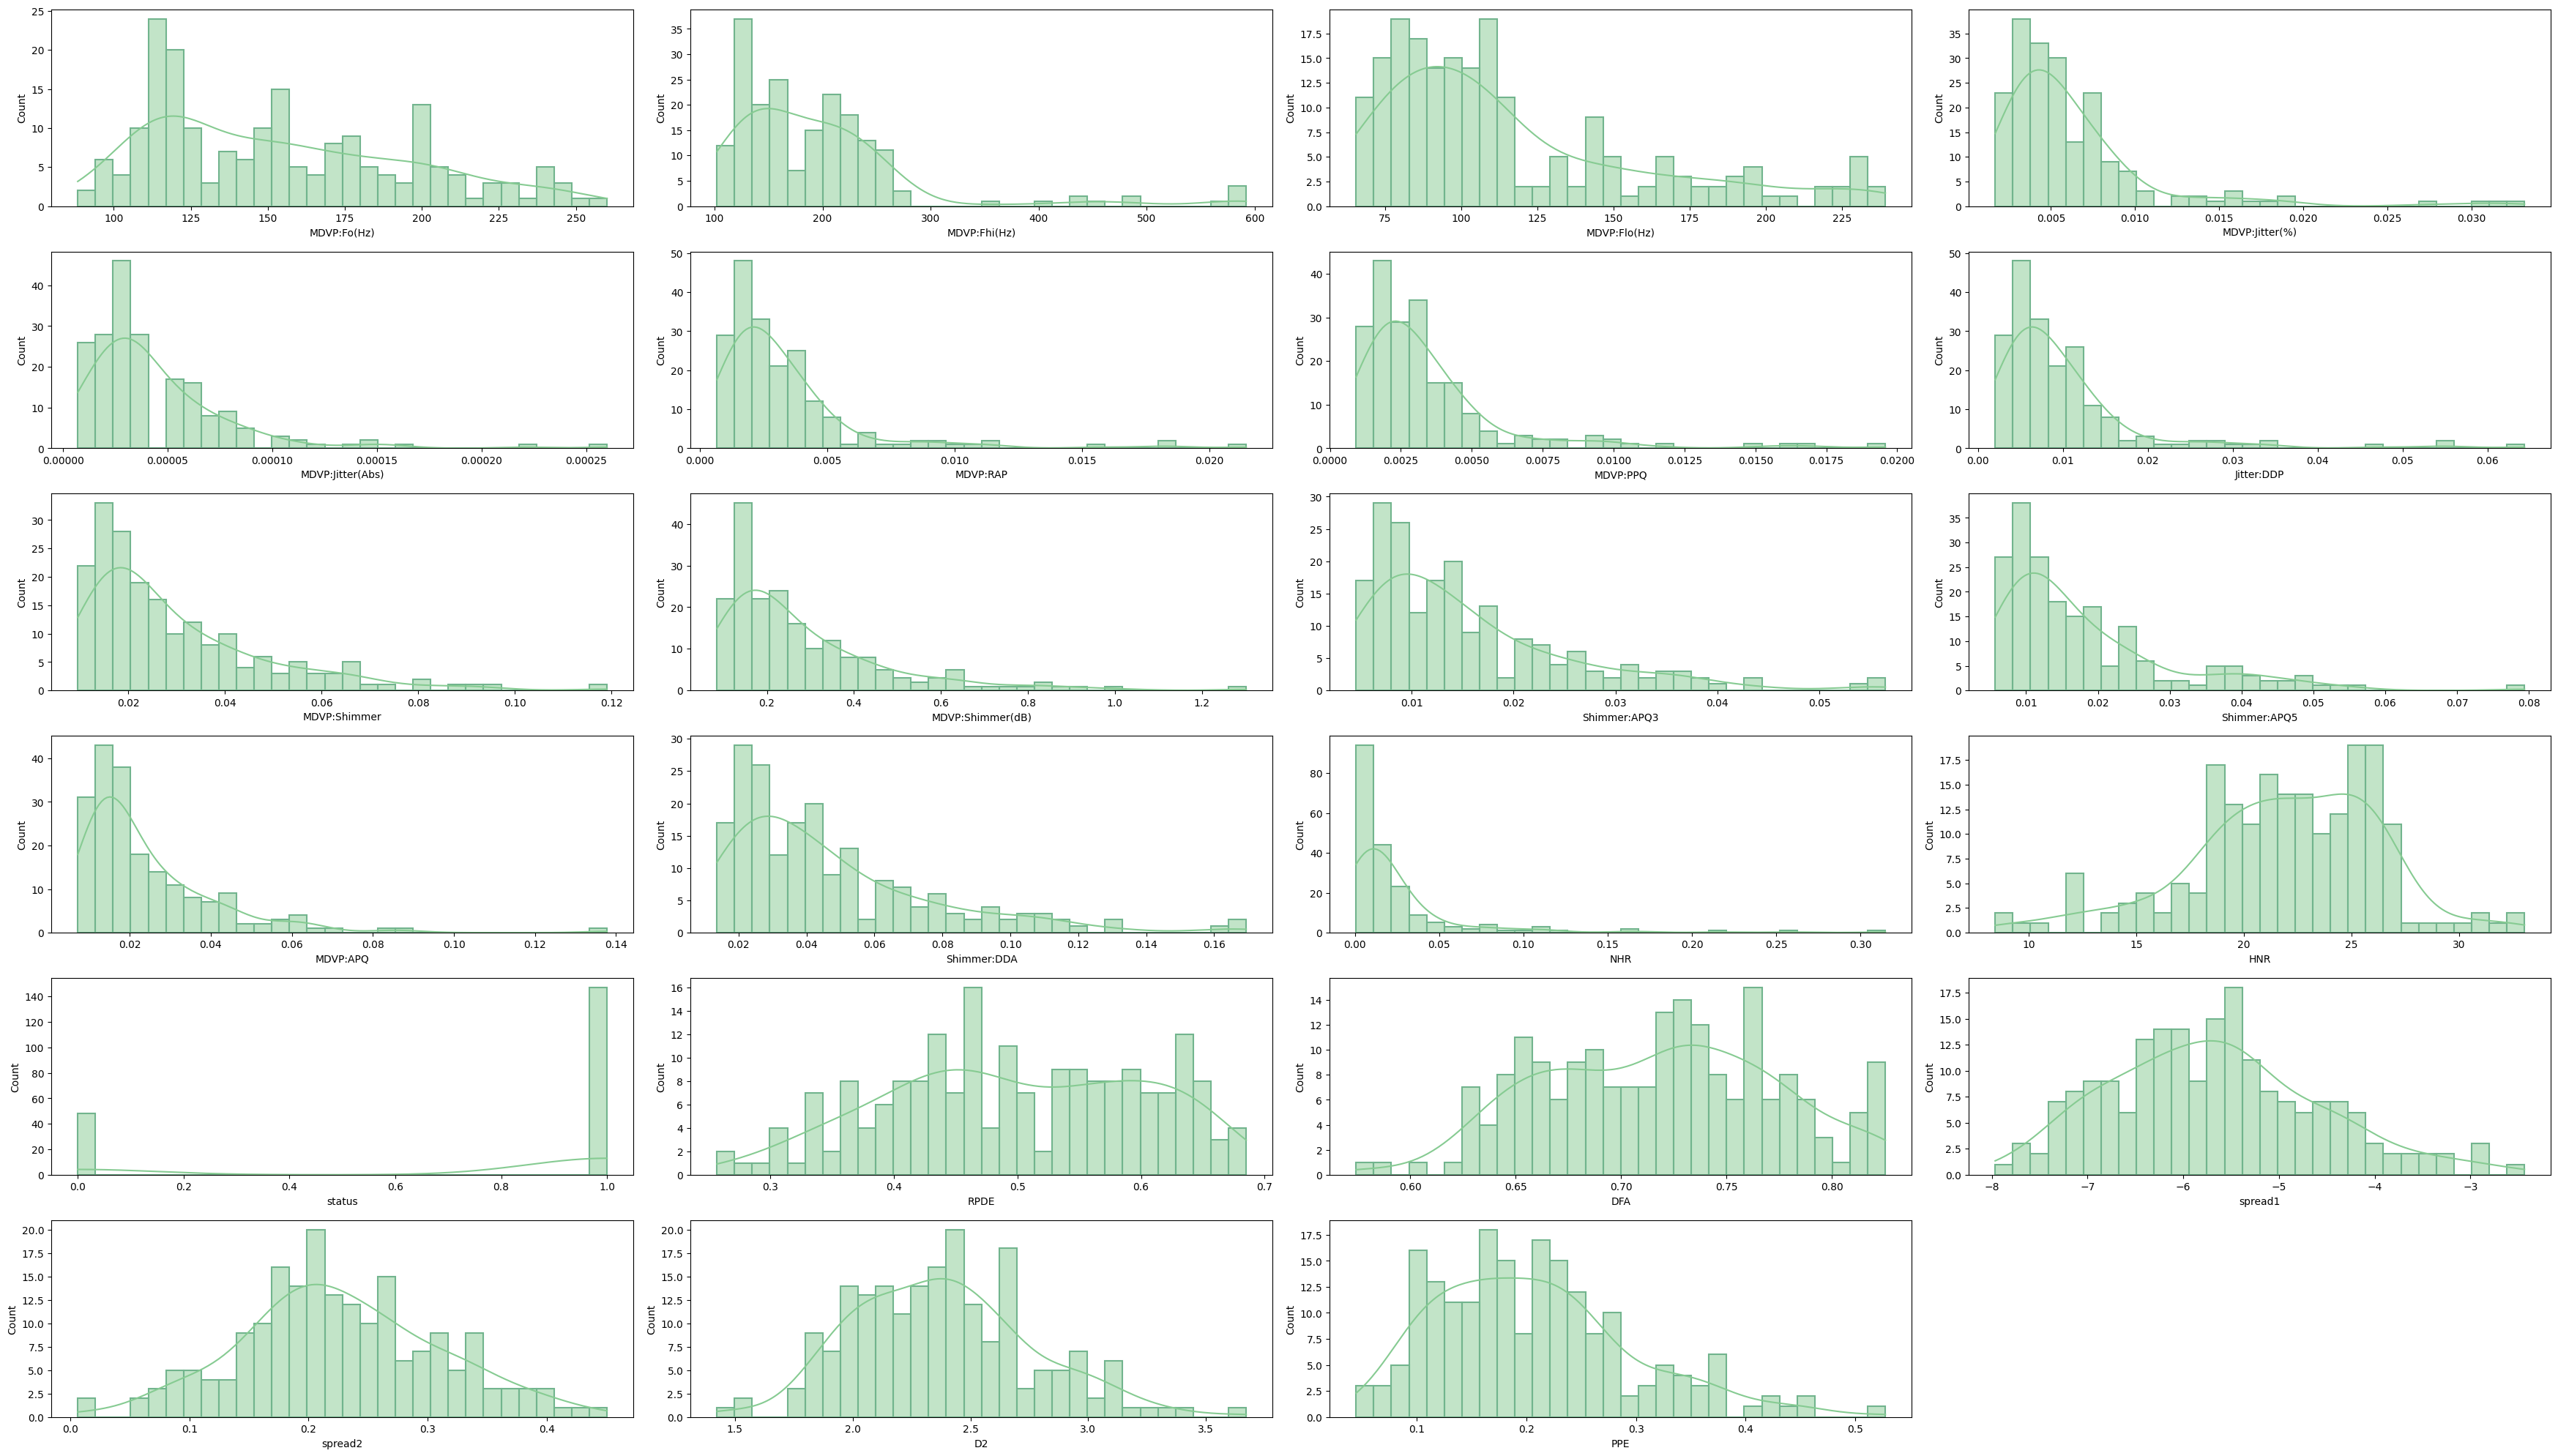

<Figure size 640x480 with 0 Axes>

In [12]:
num_plots = len(data.columns)
features = data.columns

num_rows = 6
num_cols = (num_plots + 1) // num_rows

fig, axs = plt.subplots(num_rows, num_cols, figsize=(35, 20))

for i, feature in enumerate(features):
    row = i // num_cols
    col = i % num_cols

    ax = axs[row, col]

    sns.histplot(
        data[feature],
        kde=True,
        bins=30,
        color="#86CB92",
        edgecolor="#71B48D",
        linewidth=1.5,
        ax=ax,
    )

    ax.set_xlabel(feature)
    ax.set_facecolor("none")


if num_plots % num_cols != 0:
    for col in range(num_plots % num_cols, num_cols):
        fig.delaxes(axs[num_rows - 1, col])

plt.tight_layout()
plt.show()



<h3>Distribution of features labeled by status value</h3>

There are examples in data with different values for status variable. Models will learn to generalize well and to overfit on a specific values by target class.

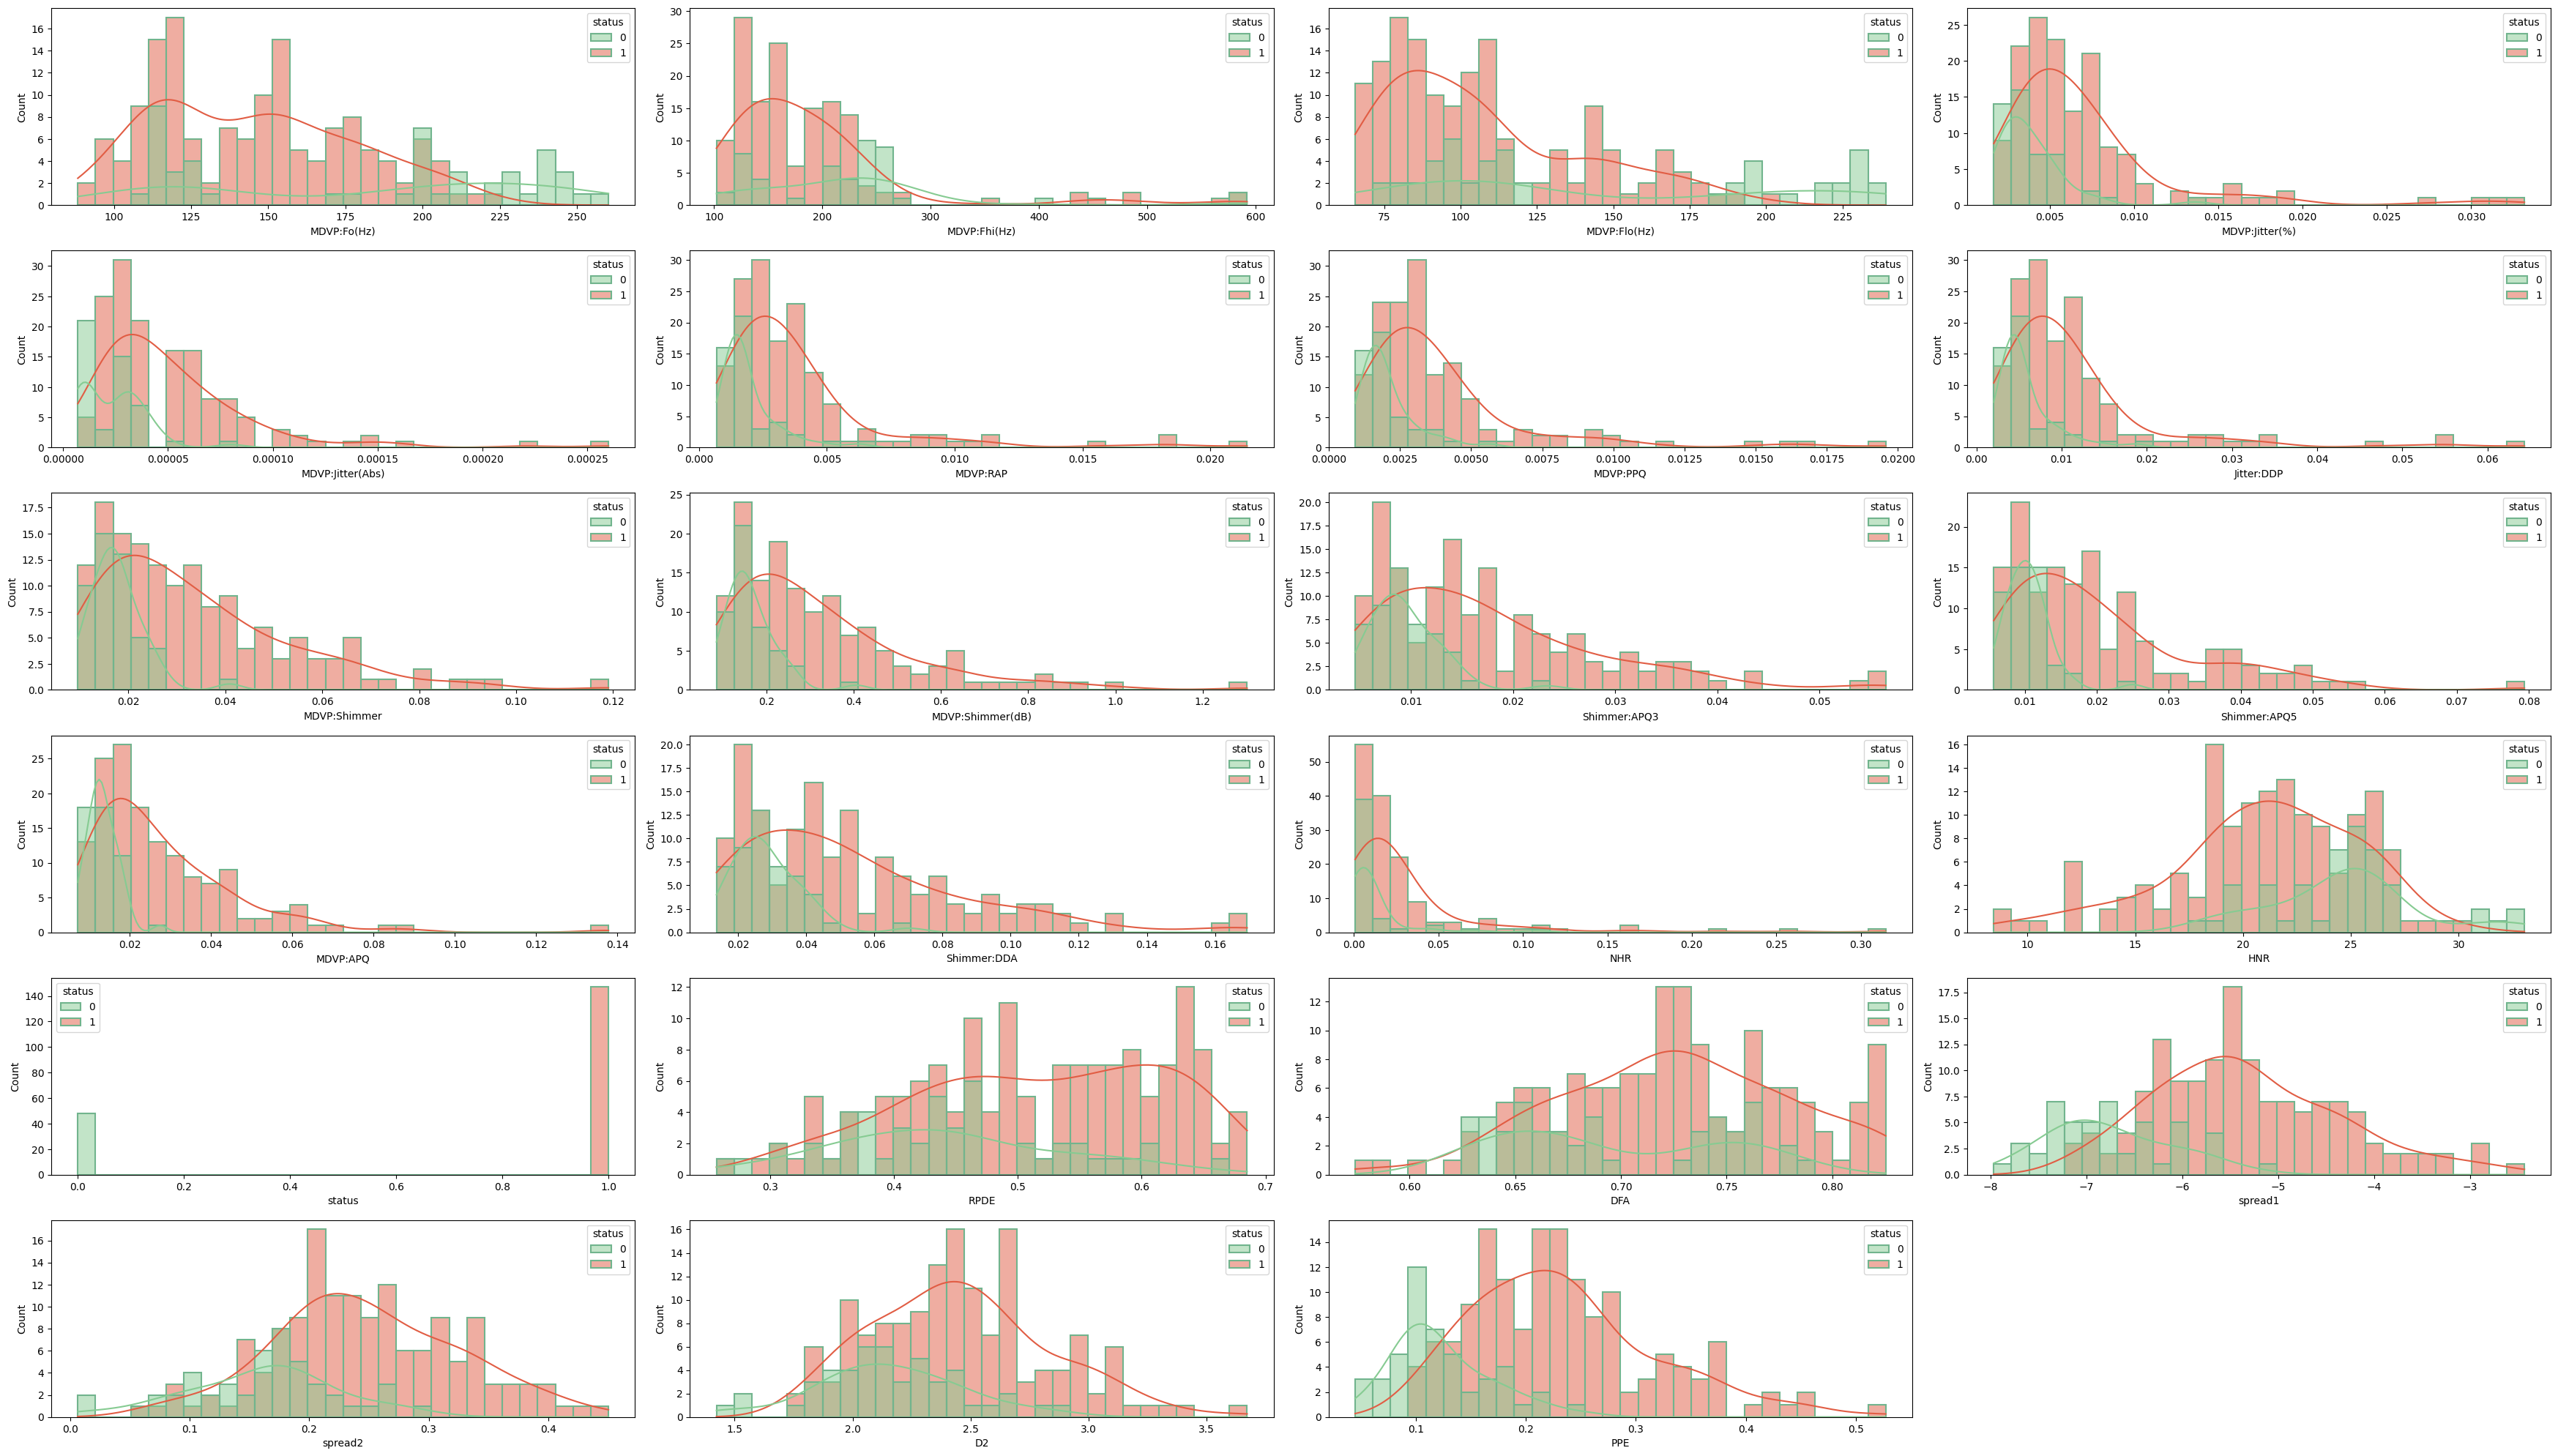

<Figure size 640x480 with 0 Axes>

In [13]:
num_plots = len(data.columns)
features = data.columns

num_rows = 6
num_cols = (num_plots + 1) // num_rows

fig, axs = plt.subplots(num_rows, num_cols, figsize=(35, 20))

for i, feature in enumerate(features):
    row = i // num_cols
    col = i % num_cols

    ax = axs[row, col]

    sns.histplot(
        data,
        x=feature,
        kde=True,
        bins=30,
        hue="status",
        palette={0: "#86CB92", 1: "#E15D44"},
        edgecolor="#71B48D",
        linewidth=1.5,
        ax=ax,
    )

    ax.set_xlabel(feature)
    ax.set_facecolor("none")

if num_plots % num_cols != 0:
    for col in range(num_plots % num_cols, num_cols):
        fig.delaxes(axs[num_rows - 1, col])

plt.tight_layout()
plt.show()



<h3>T-SNE Visuelization</h3>

Upon reducing dimensionality using t-SNE on two of the datasets, three distinct clusters emerge, with each cluster encompassing samples from two classes. Consequently, the models should be designed to capture nuanced patterns beyond mere linear boundaries between these clusters.

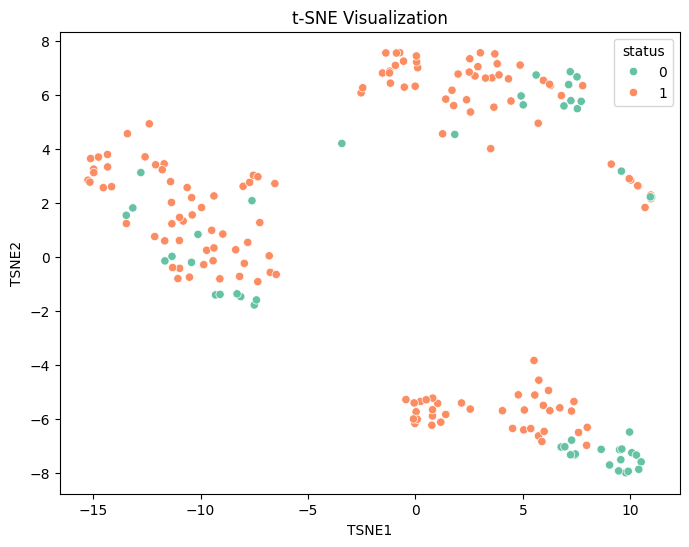

<Figure size 640x480 with 0 Axes>

In [14]:
data = pd.DataFrame(data)
data_x_tsne = data.drop(columns=["status"], axis=1)

tsne = TSNE(n_components=2, random_state=42)
data_x_tsne = tsne.fit_transform(data_x_tsne)

tsne_df = pd.DataFrame(data=data_x_tsne, columns=["TSNE1", "TSNE2"])
tsne_df["status"] = data["status"].values

plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue="status", palette="Set2")
plt.title("t-SNE Visualization")
plt.show()



<h3>Mean and Standard Deviation of Each Feature</h3>

Since mean values are not closed to 0 and standard deviation is not close to 1, data should be scaled.

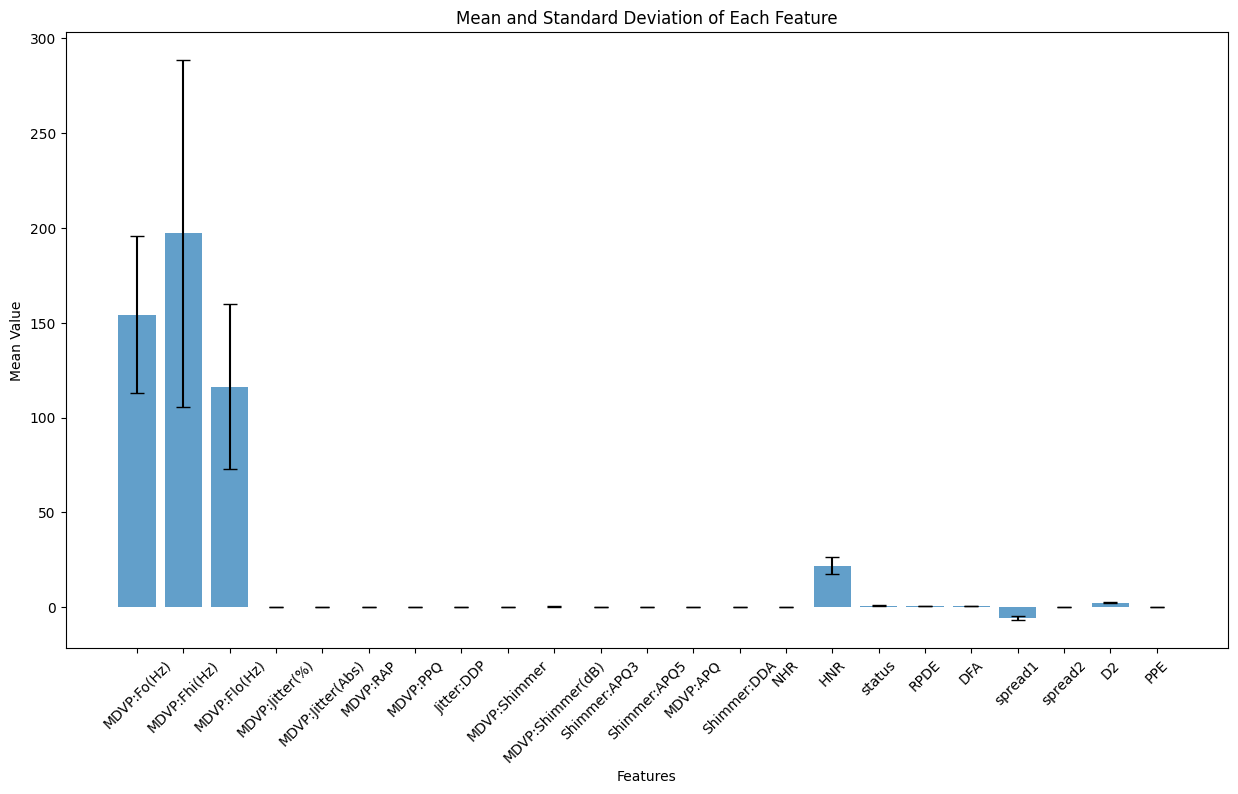

<Figure size 640x480 with 0 Axes>

In [15]:
mean_values = data.mean(axis=0)
std_values = data.std(axis=0)

# Plot mean values
plt.figure(figsize=(15, 8))
plt.bar(
    range(len(mean_values)),
    mean_values,
    yerr=std_values,
    capsize=5,
    align="center",
    alpha=0.7,
)
plt.xticks(range(len(mean_values)), data.columns, rotation=45)
plt.title("Mean and Standard Deviation of Each Feature")
plt.xlabel("Features")
plt.ylabel("Mean Value")
plt.show()



<h1>Models and Evaluation</h1>


<h3>Generic function which receives model and data</h3>

Here it is perfomered "Leave-One-Out Cross-Validation" (LOOCV) which means in each iteration model is trained N-1 times and evaluated on the patient which was not included in the iteration. Furthermore, voting is applied on prediction results for each patient.

In [16]:
def leave_one_patient_out_cross_val(model, X, y, patient_column, features):
    y_pred_voted = {}
    y_pred_voted_per_patient = {}
    scaler = MinMaxScaler()

    for patient in X[patient_column].unique():
        patient_data = X[X[patient_column] == patient]
        patient_features = patient_data[features]
        patient_labels = y[X[patient_column] == patient]

        scaled_features = scaler.fit_transform(patient_features)

        other_data = X[X[patient_column] != patient]
        other_features = other_data[features]
        other_labels = y[X[patient_column] != patient]

        other_features_scaled = scaler.transform(other_features)

        model.fit(other_features_scaled, other_labels)

        y_pred = model.predict(scaled_features).ravel()

        majority_vote = pd.Series(y_pred).mode().iloc[0]
        y_pred_voted[patient] = [majority_vote] * len(patient_labels)

        y_pred_voted_per_patient[patient] = majority_vote

    y_true = []

    for patient in y_pred_voted.items():
        y_true.extend(y[X[patient_column] == patient])

    y_pred_voted = [value for values in y_pred_voted.values() for value in values]


    return (
        y_pred_voted,
        y_pred_voted_per_patient,
    )

<h3>Generic function which calculates and plot ROC Curve and confusion matrix</h3>

In [19]:
def plot_roc_and_confusion_matrix(y_pred):
    fpr, tpr, thresholds = roc_curve(df["status"], y_pred)
    auc = roc_auc_score(df["status"], y_pred)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve')
    plt.legend()

    cm = confusion_matrix(df["status"], y_pred)

    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.show()

In [18]:
patient_column = "patient"
features = df.columns.difference(["status", patient_column]).tolist()

y_true_per_patient = {}

for patient in df[patient_column].unique():
    y_true_per_patient[patient] = df.loc[df[patient_column] == patient, "status"].iloc[
        0
    ]

<h3>Generic function for table with metrics</h3>

In [20]:
def print_metrics_table(y_true, y_pred, model_name="Model"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    metrics_table = [
        ["Accuracy", accuracy],
        ["Precision", precision],
        ["Recall", recall],
        ["F1 Score", f1]
    ]

    print(f"\nMetrics for {model_name}:\n")
    print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="pretty"))

<h3>Random Forest Classifier </h3>

In [21]:
model_random_forest = RandomForestClassifier(random_state=42)
(
    y_pred_voted_random_forest,
    y_pred_voted_per_patient_random_forest,
) = leave_one_patient_out_cross_val(
    model_random_forest, df, df["status"], patient_column, features
)


Metrics for Random Forest:

+-----------+--------------------+
|  Metric   |       Value        |
+-----------+--------------------+
| Accuracy  | 0.7846153846153846 |
| Precision | 0.8181818181818182 |
|  Recall   | 0.9183673469387755 |
| F1 Score  | 0.8653846153846154 |
+-----------+--------------------+


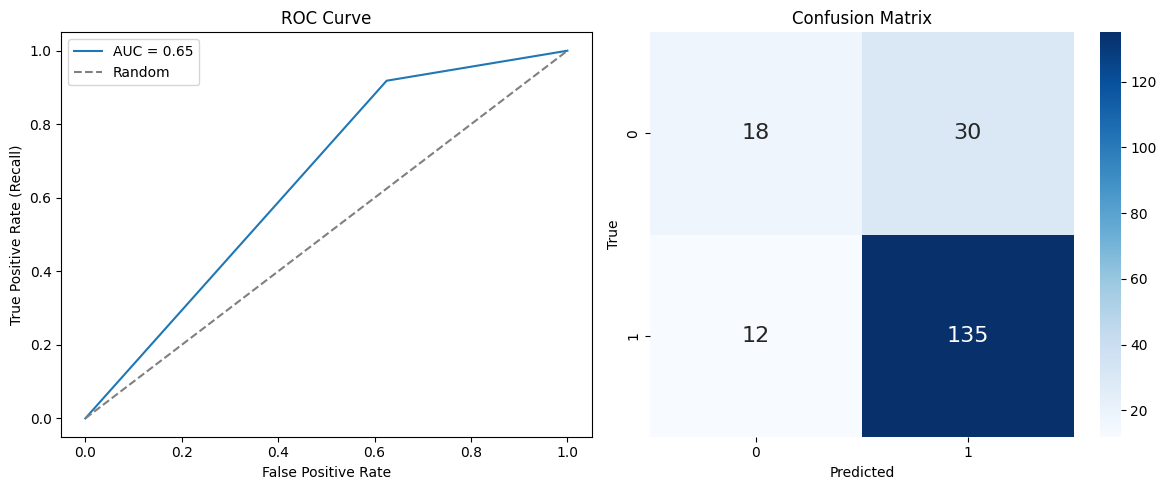

<Figure size 640x480 with 0 Axes>

In [22]:
print_metrics_table(df["status"], y_pred_voted_random_forest, model_name="Random Forest")
plot_roc_and_confusion_matrix(y_pred_voted_random_forest)

<h3>Logistic Regression</h3>

In [21]:
model_logistic = LogisticRegression(random_state=12)
(
    y_pred_voted_logistic,
    y_pred_voted_per_patient_logistic,
) = leave_one_patient_out_cross_val(
    model_logistic, df, df["status"], patient_column, features
)

c:\Users\User\Desktop\Parkinson's disease detection\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\User\Desktop\Parkinson's disease detection\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.


Metrics for Logistic Regression:

+-----------+--------------------+
|  Metric   |       Value        |
+-----------+--------------------+
| Accuracy  | 0.8153846153846154 |
| Precision | 0.8490566037735849 |
|  Recall   | 0.9183673469387755 |
| F1 Score  | 0.8823529411764707 |
+-----------+--------------------+


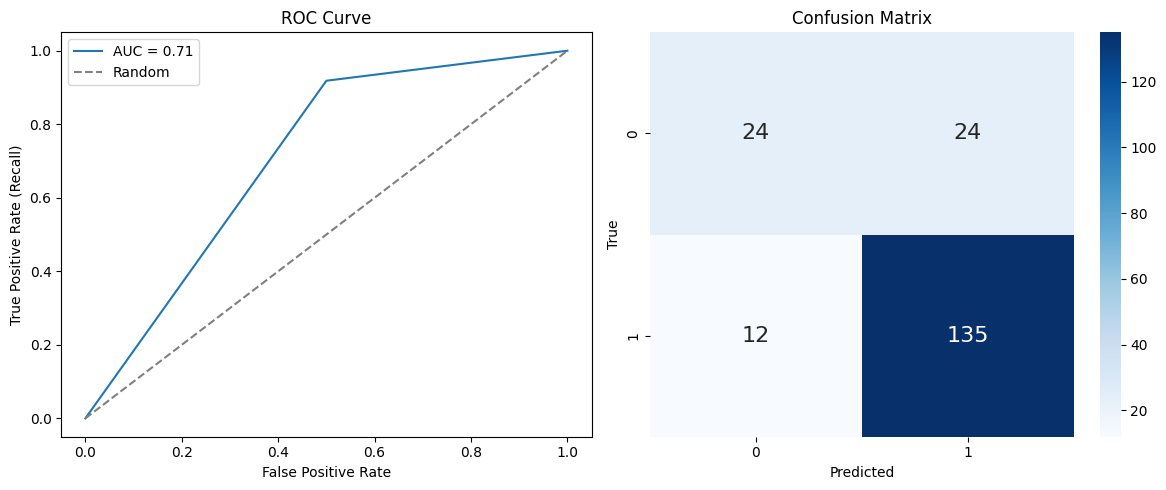

In [22]:
print_metrics_table(df["status"], y_pred_voted_logistic, model_name="Logistic Regression")
plot_roc_and_confusion_matrix(y_pred_voted_logistic)

<h3>KNeighbors Classifier </h3>

In [23]:
model_knn = KNeighborsClassifier(n_neighbors=6)
(
    y_pred_voted_knn,
    y_pred_voted_per_patient_knn
) = leave_one_patient_out_cross_val(
    model_knn, df, df["status"], patient_column, features
)


Metrics for KNeighbors Classifier:

+-----------+--------------------+
|  Metric   |       Value        |
+-----------+--------------------+
| Accuracy  | 0.7230769230769231 |
| Precision | 0.8297872340425532 |
|  Recall   | 0.7959183673469388 |
| F1 Score  |       0.8125       |
+-----------+--------------------+


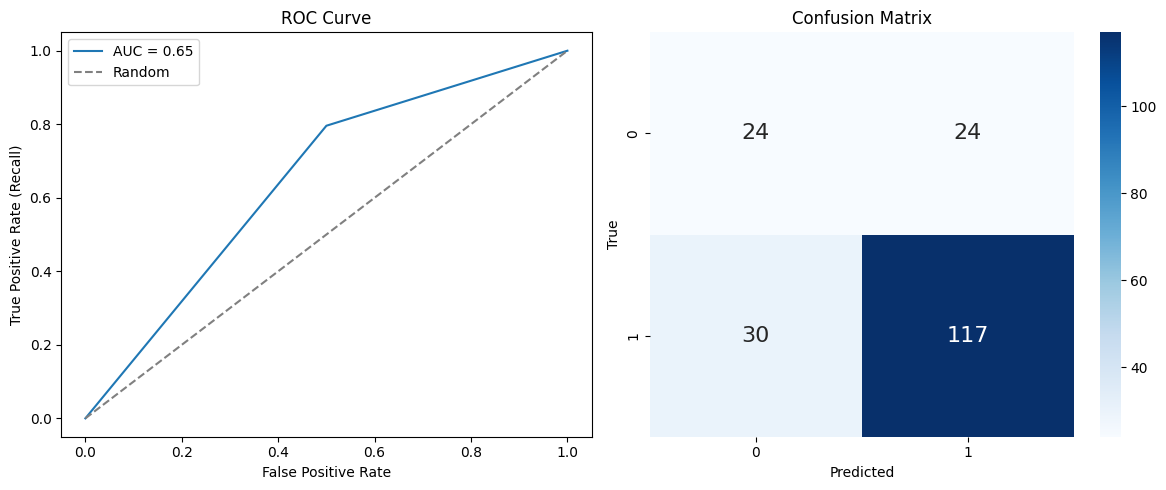

In [24]:
print_metrics_table(df["status"], y_pred_voted_knn, model_name="KNeighbors Classifier")
plot_roc_and_confusion_matrix(y_pred_voted_knn)

<h3>XGBoost Classifier</h3>

In [25]:
model_xgboost = XGBClassifier(random_state=42)
(
    y_pred_voted_xgboost,
    y_pred_voted_per_patient_xgboost,
) = leave_one_patient_out_cross_val(
    model_xgboost, df, df["status"], patient_column, features
)


Metrics for XGBClassifier:

+-----------+--------------------+
|  Metric   |       Value        |
+-----------+--------------------+
| Accuracy  | 0.8461538461538461 |
| Precision | 0.8305084745762712 |
|  Recall   |        1.0         |
| F1 Score  | 0.9074074074074074 |
+-----------+--------------------+


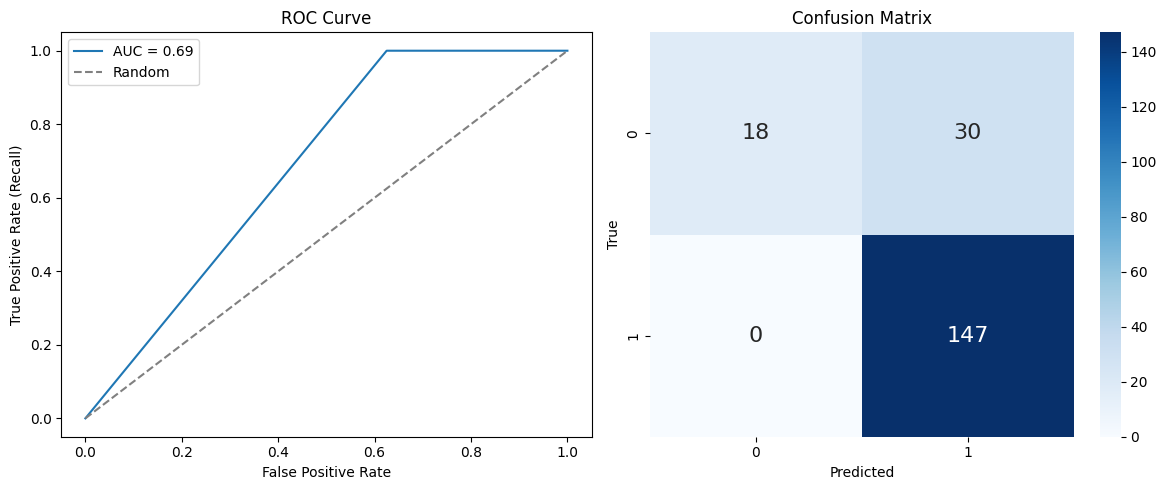

In [26]:
print_metrics_table(df["status"], y_pred_voted_xgboost, model_name="XGBClassifier")
plot_roc_and_confusion_matrix(y_pred_voted_xgboost)

<h3>Decision Tree Classifier </h3>

In [27]:
model_decision_tree = DecisionTreeClassifier(random_state=42)
(
    y_pred_voted_decision_tree,
    y_pred_voted_per_patient_decision_tree,
) = leave_one_patient_out_cross_val(
    model_decision_tree, df, df["status"], patient_column, features
)


Metrics for Decision Tree Classifier:

+-----------+--------------------+
|  Metric   |       Value        |
+-----------+--------------------+
| Accuracy  | 0.7846153846153846 |
| Precision | 0.8431372549019608 |
|  Recall   | 0.8775510204081632 |
| F1 Score  |        0.86        |
+-----------+--------------------+


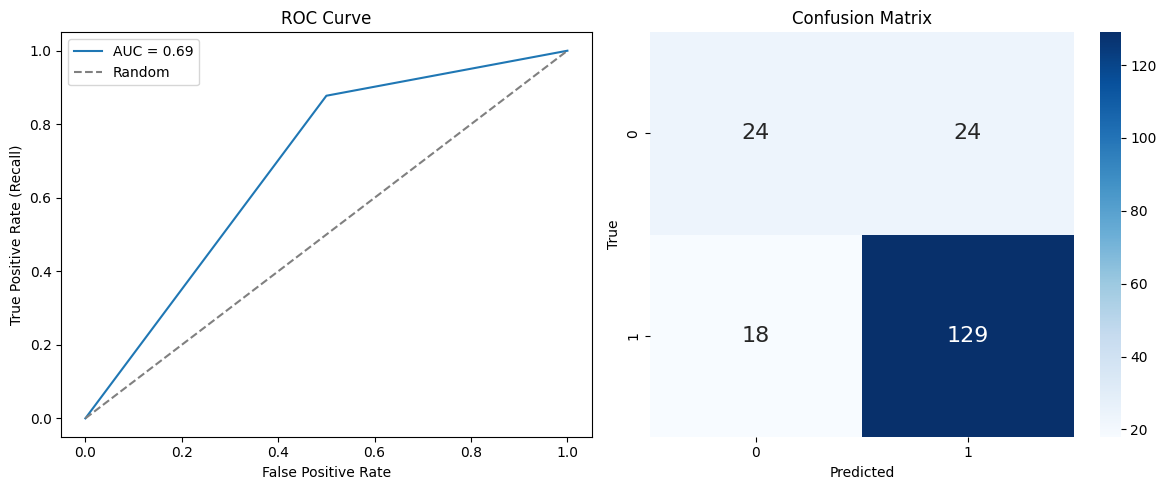

In [28]:
print_metrics_table(df["status"], y_pred_voted_decision_tree, model_name="Decision Tree Classifier")
plot_roc_and_confusion_matrix(y_pred_voted_decision_tree)

<h3>Neural Network - MLP Classifier</h3>

In [29]:
model_mlp = MLPClassifier(hidden_layer_sizes=(45,), max_iter=20, random_state=12)

(
    y_pred_voted_mlp,
    y_pred_voted_per_patient_mlp,
) = leave_one_patient_out_cross_val(
    model_decision_tree, df, df["status"], patient_column, features
)


Metrics for MLP Classifier:

+-----------+--------------------+
|  Metric   |       Value        |
+-----------+--------------------+
| Accuracy  | 0.7846153846153846 |
| Precision | 0.8431372549019608 |
|  Recall   | 0.8775510204081632 |
| F1 Score  |        0.86        |
+-----------+--------------------+


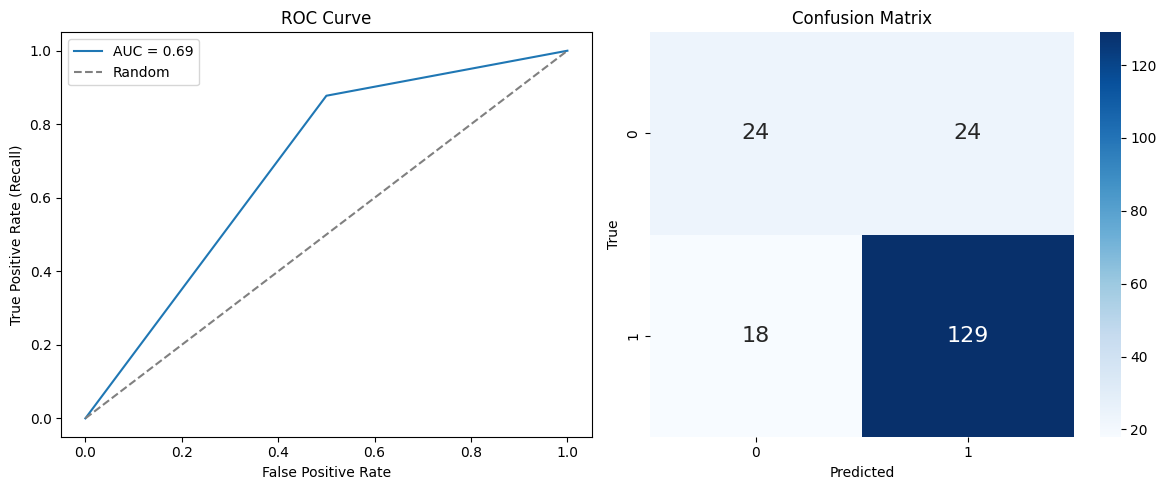

In [30]:
print_metrics_table(df["status"], y_pred_voted_mlp, model_name="MLP Classifier")
plot_roc_and_confusion_matrix(y_pred_voted_mlp)

<h3>Generic function to display voted predicted and true value by patient </h3>

In [31]:
def plot_comparison(y_pred_voted_per_patient_model, model_name):
    patients = list(y_pred_voted_per_patient_model.keys())
    predicted = list(y_pred_voted_per_patient_model.values())
    true = list(y_true_per_patient.values())

    colors = sns.color_palette("pastel", 2)

    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35

    bar1 = sns.barplot(x=patients, y=predicted, color=colors[0], label='Predicted')
    bar2 = sns.barplot(x=patients, y=true, color=colors[1], label='True')

    ax.set_xlabel('Patients')
    ax.set_ylabel('Prediction')
    ax.set_title('Comparison of Predicted vs True Values ' + model_name)
    ax.legend()

    plt.show()

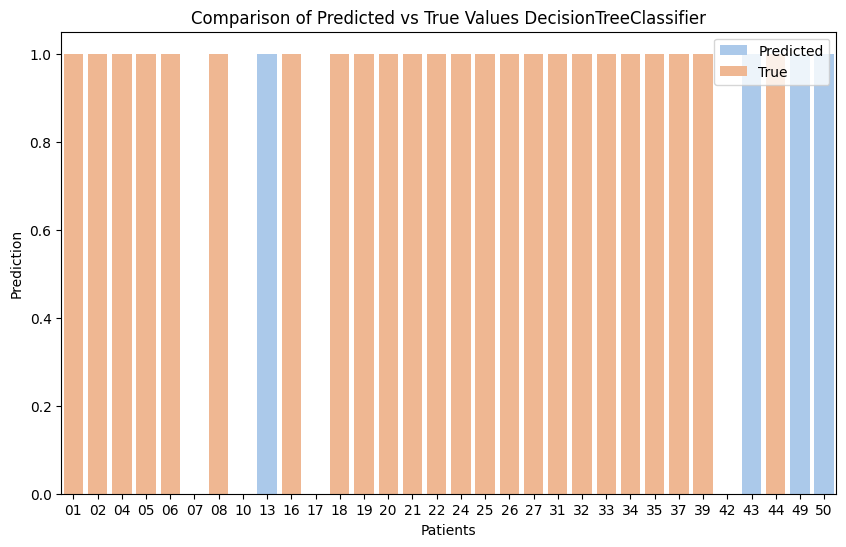

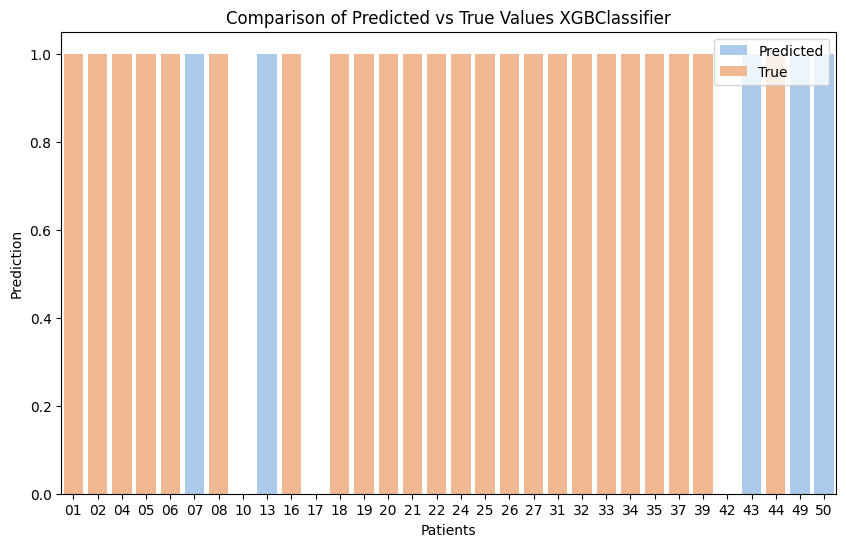

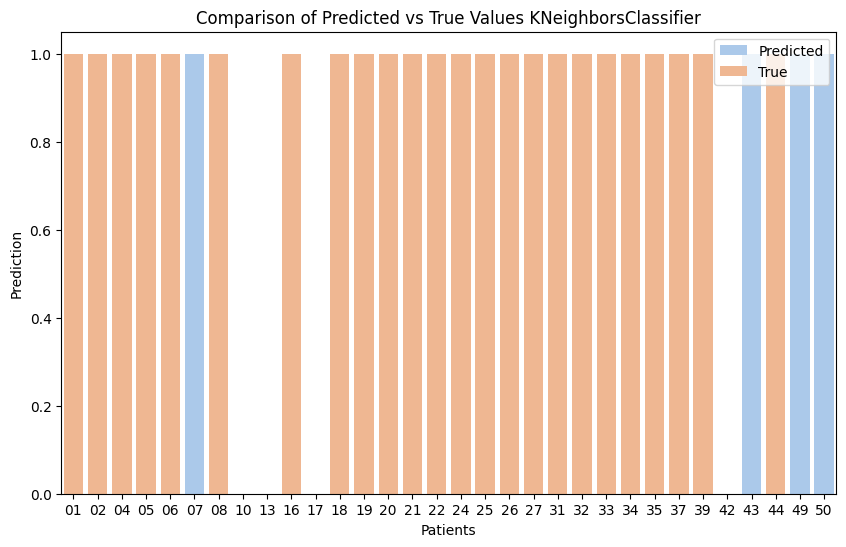

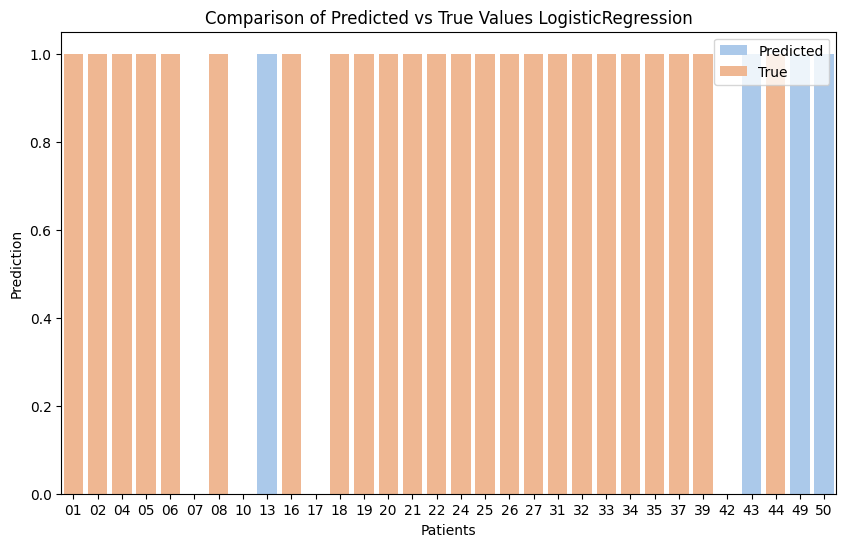

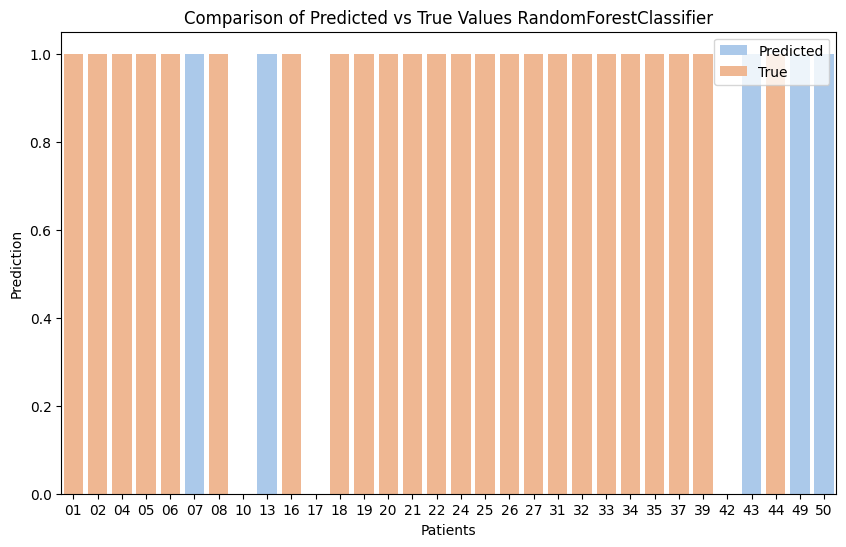

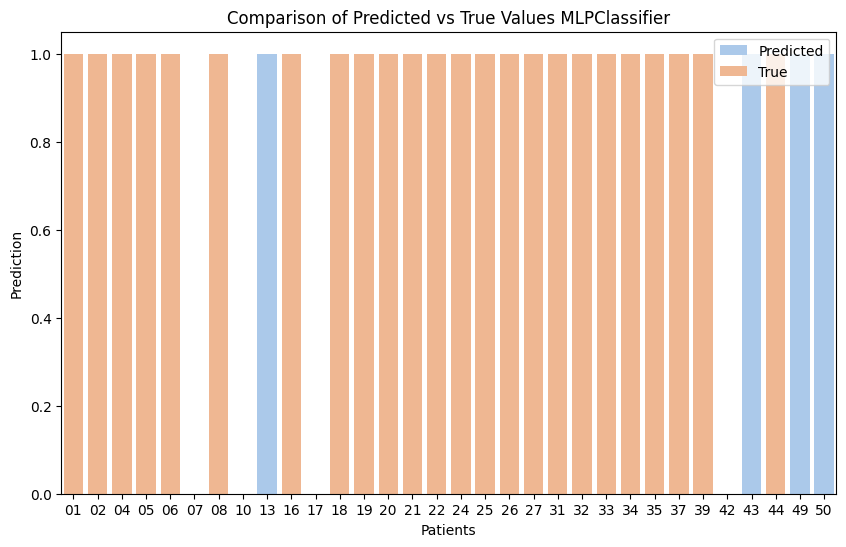

In [32]:
plot_comparison(y_pred_voted_per_patient_decision_tree, "DecisionTreeClassifier")
plot_comparison(y_pred_voted_per_patient_xgboost, "XGBClassifier")
plot_comparison(y_pred_voted_per_patient_knn, "KNeighborsClassifier")
plot_comparison(y_pred_voted_per_patient_logistic, "LogisticRegression")
plot_comparison(y_pred_voted_per_patient_random_forest,"RandomForestClassifier")
plot_comparison(y_pred_voted_per_patient_mlp,"MLPClassifier")

<h1>Conclusion</h1>

In medical cases like this one, where it is crucial not to miss positive cases, evaluating the best metric is recall—the ratio of correctly predicted positive observations to all observations in the actual class. Additionally, the precision metric, as the ratio of correctly predicted positive observations to the total predicted positives, is equally valuable. To order models, the F1 score, which is the mean of recall and precision, is considered. Therefore, XGBClassifier has the highest value at 0.907, followed by Logistic Regression with 0.882. The remaining models have the same F1 score of 0.86.

Furthermore, the ROC curve provides a comprehensive view of a model's performance, allowing informed decisions about the trade-offs between sensitivity and specificity. The Logistic Regression model achieves the best AUC value at 0.71, followed by XGBClassifier, Decision Tree Classifier, and MLPClassifier with 0.69, and KNeighbors Classifier and RandomForest Classifier with 0.65.

The RandomForestClassifier has the highest number of missed classifications, with 5 patients out of 32, while the remaining models each have 4 missed detections, but generally XGBClassifier is the best model.

In summary, this project aims to detect Parkinson's disease from voice records of patients, leads to smart health systems and it could become a valid test for this disease, considering the current lack of such a test.